### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [79]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import time



In [ ]:
# Verificar a estruura de um arquivo
#abril2018_df = pd.read_csv('dataset/abril2018.csv')
#display(abril2018_df)

# Importa todos os arquivos da pasta dataset
caminho_bases = pathlib.Path('dataset')

# Visualizar o resultado
for arquivo in caminho_bases.iterdir():
    print(arquivo.name)

abril2019.csv
abril2020.csv
agosto2019.csv
dezembro2019.csv
fevereiro2019.csv
fevereiro2020.csv
janeiro2019.csv
janeiro2020.csv
julho2018.csv
julho2019.csv
junho2019.csv
maio2019.csv
maio2020.csv
maro2019.csv
maro2020.csv
novembro2019.csv
outubro2019.csv
setembro2019.csv


In [2]:
# Mapeamento dos meses abreviados para número
meses = {
    'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4,
    'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8,
    'set': 9, 'out': 10, 'nov': 11, 'dez': 12
}

# Caminho da pasta com os arquivos CSV
caminho_bases = pathlib.Path('dataset')

# Lista para armazenar os DataFrames
lista_df = []

# Itera pelos arquivos da pasta
for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3].lower()
    
    if nome_mes not in meses:
        print(f"Mês não reconhecido em: {arquivo.name}")
        continue

    mes = meses[nome_mes]
    
    try:
        ano = int(arquivo.name[-8:].replace('.csv', ''))
    except ValueError:
        print(f"Ano inválido em: {arquivo.name}")
        continue

    # Lê o arquivo
    df = pd.read_csv(arquivo, low_memory=False)
    
    # Adiciona as colunas de data
    df['ano'] = ano
    df['mes'] = mes
    
    # Adiciona à lista
    lista_df.append(df)

# Concatena todos os DataFrames em um só
base_airbnb = pd.concat(lista_df, ignore_index=True)

In [ ]:
display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ano,mes
0,17878,https://www.airbnb.com/rooms/17878,20190416181629,2019-04-16,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.10,2019,4
1,25026,https://www.airbnb.com/rooms/25026,20190416181629,2019-04-16,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,strict_14_with_grace_period,t,t,3,3.0,0.0,0.0,2.12,2019,4
2,31560,https://www.airbnb.com/rooms/31560,20190416181629,2019-04-17,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,2.33,2019,4
3,35636,https://www.airbnb.com/rooms/35636,20190416181629,2019-04-17,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,"The location is extremely convenient, safe and...",This cosy apartment is just a few steps away ...,none,The apartment street is very quiet and safe ....,...,strict_14_with_grace_period,t,t,1,1.0,0.0,0.0,2.20,2019,4
4,35764,https://www.airbnb.com/rooms/35764,20190416181629,2019-04-16,COPACABANA SEA BREEZE - RIO,Our newly renovated studio is located in the b...,"FEEL LIKE YOUR HOME LIVING AS ""CARIOCA"" LOCAL ...",Our newly renovated studio is located in the b...,none,Our guests will experience living with a local...,...,strict_14_with_grace_period,f,t,1,1.0,0.0,0.0,2.80,2019,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639869,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,flexible,f,f,15,15.0,0.0,0.0,NaN,2019,9
639870,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,flexible,f,f,1,1.0,0.0,0.0,NaN,2019,9
639871,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,strict_14_with_grace_period,f,f,29,23.0,6.0,0.0,NaN,2019,9
639872,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,strict_14_with_grace_period,f,f,1,1.0,0.0,0.0,NaN,2019,9


In [ ]:
print(base_airbnb.mes)
print(base_airbnb.ano)

0         4
1         4
2         4
3         4
4         4
         ..
639869    9
639870    9
639871    9
639872    9
639873    9
Name: mes, Length: 639874, dtype: int64
0         2019
1         2019
2         2019
3         2019
4         2019
          ... 
639869    2019
639870    2019
639871    2019
639872    2019
639873    2019
Name: ano, Length: 639874, dtype: int64


## Limpeza

Excluindo os atributos que não contribuiem para a formação do valor da diaria.
- Tipos de colunas que vamos excluir:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais

In [ ]:
# Cria um arquivo csv com os primeiros 1000 registros separados por ;
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

In [ ]:
base_airbnb

,id,listing_url,scrape_id,last_scraped,name,summary,description,experiences_offered,picture_url,host_id,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Other_bed,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,Please note that special rates apply for New Y...,none,https://a0.muscache.com/im/pictures/65320518/3...,68997,...,True,False,False,False,False,True,False,False,True,False
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...","Our apartment is a little gem, everyone loves ...",none,https://a0.muscache.com/im/pictures/3003965/68...,102840,...,True,False,False,False,False,True,False,False,True,False
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,https://a0.muscache.com/im/pictures/83114449/2...,135635,...,True,False,False,False,False,True,False,False,True,False
5,35636,https://www.airbnb.com/rooms/35636,20180414160018,2018-04-15,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,This cosy apartment is just a few steps away ...,none,https://a0.muscache.com/im/pictures/20009355/3...,153232,...,True,False,False,False,False,True,False,False,True,False
6,35764,https://www.airbnb.com/rooms/35764,20180414160018,2018-04-14,COPACABANA SEA BREEZE - RIO,Our newly renovated studio is located in the b...,Our newly renovated studio is located in the b...,none,https://a0.muscache.com/im/pictures/6992951/b8...,153691,...,True,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902204,38844100,https://www.airbnb.com/rooms/38844100,20190923212307,2019-09-24,Apartamento em Copacabana - 2 min das praias,"Apartamento novo, no coracão do Arpoador, com ...","Apartamento novo, no coracão do Arpoador, com ...",none,https://a0.muscache.com/im/pictures/fbfebdfe-6...,296061948,...,True,False,False,False,False,True,True,False,False,False
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...","Em estilo contemporâneo, o Transamerica Prime ...",none,https://a0.muscache.com/im/pictures/83218b9f-6...,280625693,...,True,False,False,False,False,True,True,False,False,False
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...","Confortável apartamento, 2 quartos , sendo 1 s...",none,https://a0.muscache.com/im/pictures/4396b640-8...,58499305,...,True,False,False,False,False,True,True,False,False,False
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,Cobertura alto nivel,none,https://a0.muscache.com/im/pictures/3ec68ed1-b...,9802173,...,True,False,False,False,False,True,False,False,False,True


In [ ]:
# Coluna experiences_offered possui uma quantidade significativa de None
print((base_airbnb['experiences_offered'].value_counts()).value_counts())
# Todos os registros ssão iguais

count
639874    1
Name: count, dtype: int64


In [ ]:
# print(base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count'])
# São colunas iguais
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())
# Somente 460 registro são falso

True     639522
False       352
Name: count, dtype: int64


In [ ]:
print(base_airbnb['square_feet'].isnull().sum())
# A grande maioria e nulo

630292


### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [3]:
colunas  = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

# Filtrar as colunas selecionadas da base completa
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,within an hour,100%,f,2.0,-22.96592,-43.17896,Condominium,Entire home/apt,5,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2019,4
1,within a day,88%,f,3.0,-22.97712,-43.19045,Apartment,Entire home/apt,3,1.0,...,10.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,4
2,within an hour,100%,t,1.0,-22.98302,-43.21427,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,4
3,within a few hours,100%,t,1.0,-22.98816,-43.19359,Apartment,Entire home/apt,3,1.5,...,9.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2019,4
4,within an hour,100%,t,1.0,-22.98127,-43.19046,Loft,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639869,within an hour,93%,f,0.0,-23.00318,-43.34284,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
639870,NaN,NaN,f,0.0,-22.96664,-43.39345,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
639871,within a few hours,74%,f,32.0,-22.96208,-43.17552,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
639872,NaN,NaN,f,0.0,-23.00340,-43.34182,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


## Tratar valores faltantes


In [ ]:
print(base_airbnb.shape)

(639874, 34)


In [ ]:
print(base_airbnb.isnull().sum())

host_response_time             263377
host_response_rate             263377
host_is_superhost                 352
host_listings_count               352
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1200
bedrooms                          682
beds                             2130
bed_type                            0
amenities                           0
price                               0
security_deposit               289726
cleaning_fee                   215517
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           306914
review_scores_accuracy         307276
review_scores_cleanliness      307176
review_scores_checkin          307304
review_score

In [4]:
# As colunas que possuem mais de 300k nulo serão excluidas (host_response_time, host_response_rate, review_scores_rating,
# review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location,
# review_scores_value, security_deposit, cleaning_fee
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() >= 200000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost            352
host_listings_count          352
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1200
bedrooms                     682
beds                        2130
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64
(639874, 23)


In [5]:
#Para as demais coluans com dados faltantes, como temos mais de 900k linhas para análise, podemos excluir essas linhas com valores faltantes.
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)

(636243, 23)


## Verificar Tipos de Dados em cada coluna

In [ ]:
print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       2.0
la

In [6]:
# price e extra_people está como object e deve ser float
# Para transformar esse valor precisa tirar o $ e a virgula
base_airbnb['price'] = base_airbnb['price'].astype(str)
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False) #Foi usado float32 para usar menos espaço de memoria

base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(str)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)


In [7]:
# Transformando os outros float64 em float32
base_airbnb['host_listings_count'] = base_airbnb['host_listings_count'].astype(np.float32, copy=False)
base_airbnb['latitude'] = base_airbnb['latitude'].astype(np.float32, copy=False)
base_airbnb['longitude'] = base_airbnb['longitude'].astype(np.float32, copy=False)
base_airbnb['bathrooms'] = base_airbnb['bathrooms'].astype(np.float32, copy=False)
base_airbnb['bedrooms'] = base_airbnb['bedrooms'].astype(np.float32, copy=False)
base_airbnb['beds'] = base_airbnb['beds'].astype(np.float32, copy=False)

In [8]:
#Tratando os int6
base_airbnb['accommodates'] = base_airbnb['accommodates'].astype(np.int32, copy=False)
base_airbnb['guests_included'] = base_airbnb['guests_included'].astype(np.int32, copy=False)
base_airbnb['minimum_nights'] = base_airbnb['minimum_nights'].astype(np.int32, copy=False)
base_airbnb['maximum_nights'] = base_airbnb['maximum_nights'].astype(np.int32, copy=False)
base_airbnb['number_of_reviews'] = base_airbnb['number_of_reviews'].astype(np.int32, copy=False)
base_airbnb['ano'] = base_airbnb['ano'].astype(np.int32, copy=False)
base_airbnb['mes'] = base_airbnb['mes'].astype(np.int32, copy=False)

In [ ]:
print(base_airbnb.dtypes)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float32
latitude                    float32
longitude                   float32
property_type                object
room_type                    object
accommodates                  int32
bathrooms                   float32
bedrooms                    float32
beds                        float32
bed_type                     object
amenities                    object
price                        object
guests_included               int32
extra_people                 object
minimum_nights                int32
maximum_nights                int32
number_of_reviews             int32
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int32
mes                           int32
dtype: object
host_is_superhost                                                           f
host_listings_count                                                       2.0
la

### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

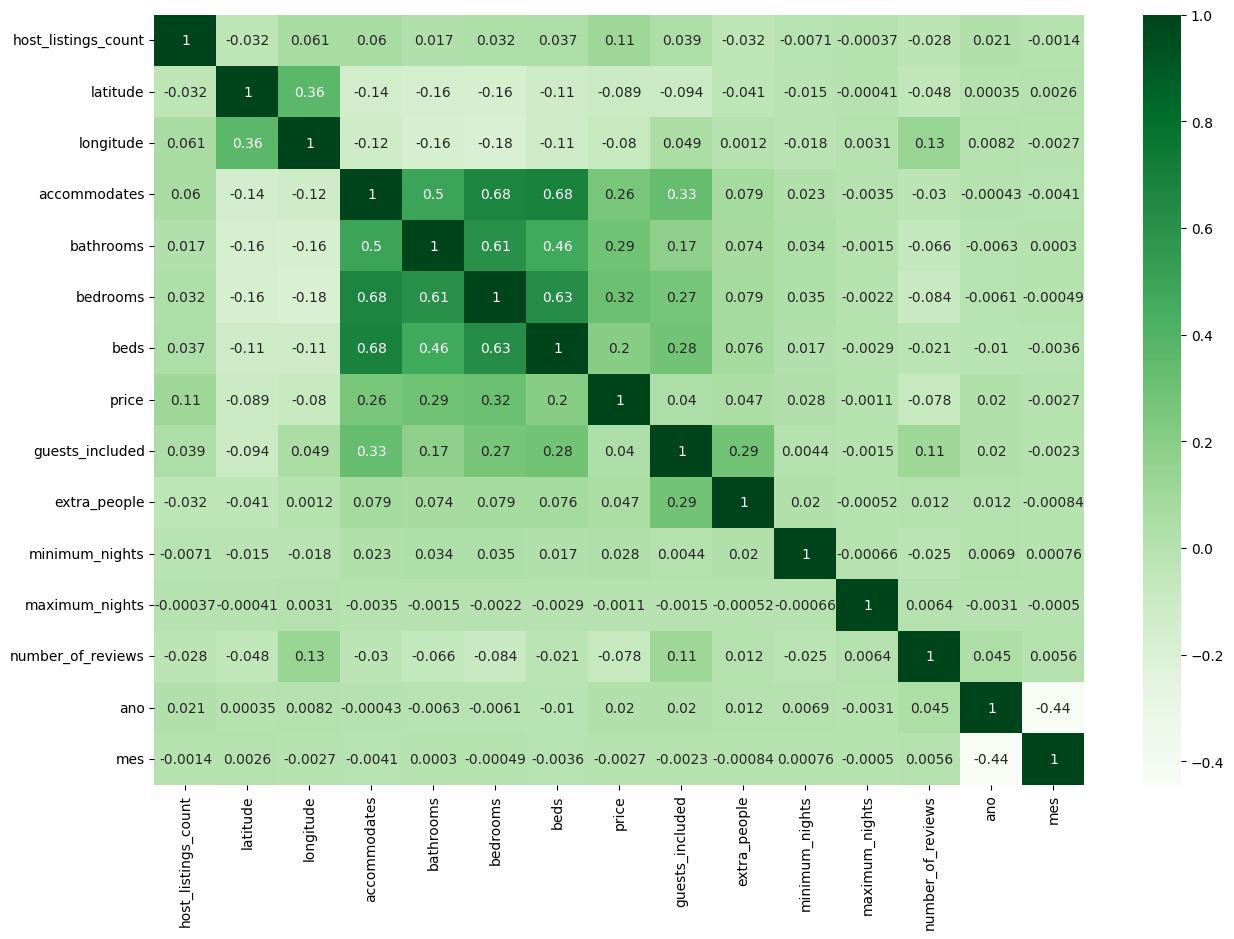

In [ ]:
# Primeiro passo, analisar as correlações entre as colunas
#print(base_airbnb.corr())
#plt.figure(figsize=(15,5))
#sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')
# Selecionar apenas as colunas numéricas
df_numerico = base_airbnb.select_dtypes(include=['number'])

# Gerar heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_numerico.corr(), annot=True, cmap='Greens')
plt.show()

# Analisando as correlações, pode-se avaliar que não existe nenhuma correlaççao direta muito forte, que poderiam ter o mesmo comportamento. Nesse caso, podemos partir para avaliação de cada um dos itens isoladamente

## Definição das funções para análise de outliers
Para definir os limites superior e inferior usaremos como regra, valores abaixo de Q1 - 1.5 x Amplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1

In [9]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude    #Limite inferior e limite superior

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(10, 3))
    sns.histplot(coluna, kde=True)

def grafico_barra(coluna):
    plt.figure(figsize=(10, 3))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))


## Análise da Coluna Price
(número contínuo)

In [ ]:
base_airbnb['price'].describe()

count      636243
unique       5766
top       $298.00
freq        10855
Name: price, dtype: object

In [ ]:
print((base_airbnb['price'] == 0).sum())

154


In [ ]:
# Excluindo as linhas com valores de alugue igual a 0
base_airbnb = base_airbnb[base_airbnb['price'] != 0]

(np.float64(-524.0), np.float64(1276.0))


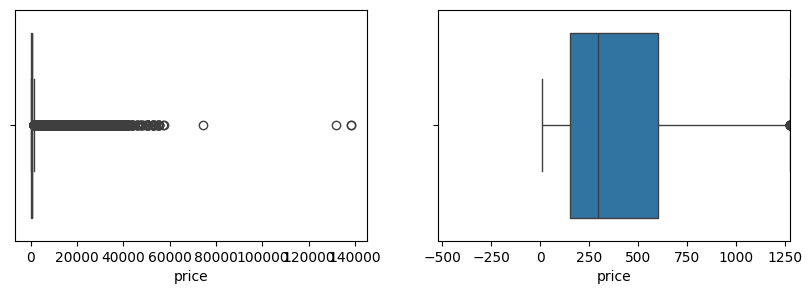

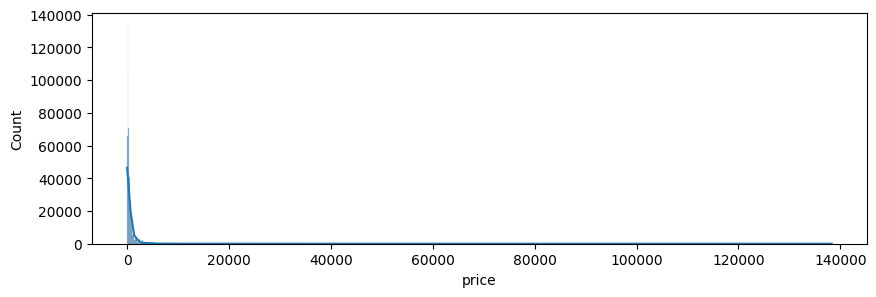

In [ ]:
print(limites(base_airbnb['price']))
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

In [10]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas.'.format(linhas_removidas))

62718 linhas removidas.


In [ ]:
base_airbnb['price'].describe()

count    573371.000000
mean        353.934326
std         283.969177
min          12.000000
25%         149.000000
50%         251.000000
75%         491.000000
max        1276.000000
Name: price, dtype: float64

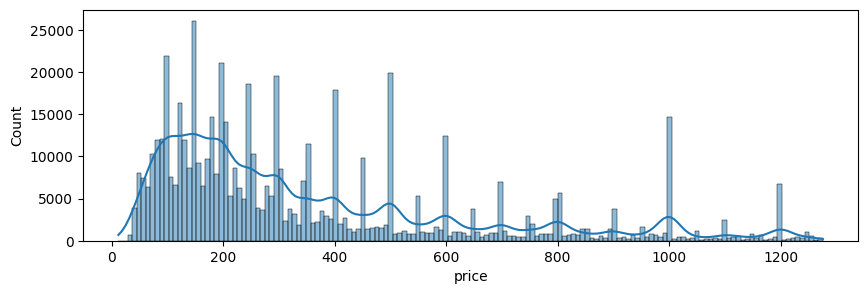

In [ ]:
# PRICE
histograma(base_airbnb['price'])

Como estamos construindo um modelo para imoveis comuns, acretido que os valores acima do limite superior que é de 1.2k os imoveis com aluguel acima desse valor (entende-se que são imoveis de alto padrão) serão excluidos do modelo. Considerando que o aluguel de imoveis de alto padrão levam em consideração outras questões.

## Análise da Coluna Extra People
(número contínuo)

In [ ]:
base_airbnb['extra_people'].describe()

count    573371.000000
mean         38.807438
std          85.139275
min           0.000000
25%           0.000000
50%           0.000000
75%          50.000000
max        5631.000000
Name: extra_people, dtype: float64

(np.float64(-75.0), np.float64(125.0))


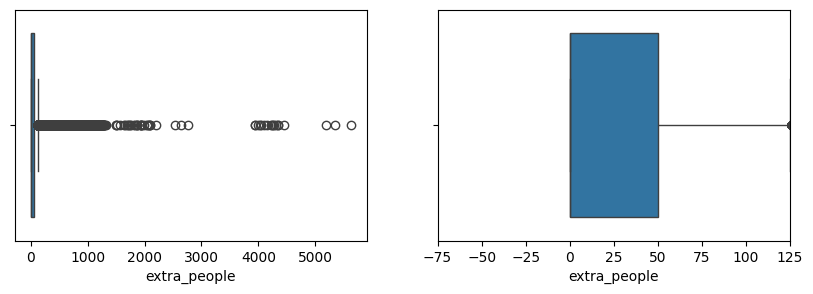

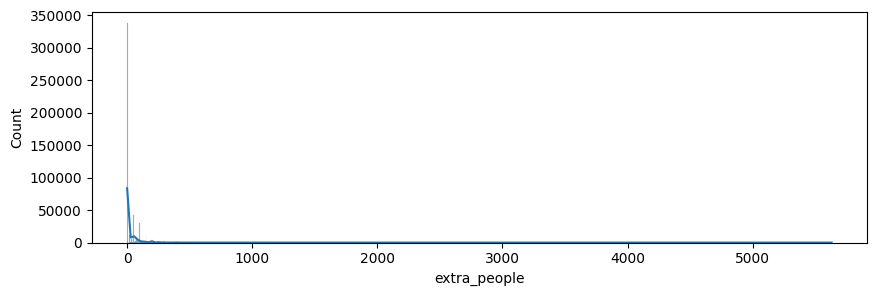

In [ ]:
print(limites(base_airbnb['extra_people']))
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])
# A grande maioria não cobra ou cobra uma taxa menor de 100. Com essa configuração, os que cobram mais de 100 estão sendo configurados como outlier. Inicialmente, irei retirar esses valores.

42291 linhas removidas.


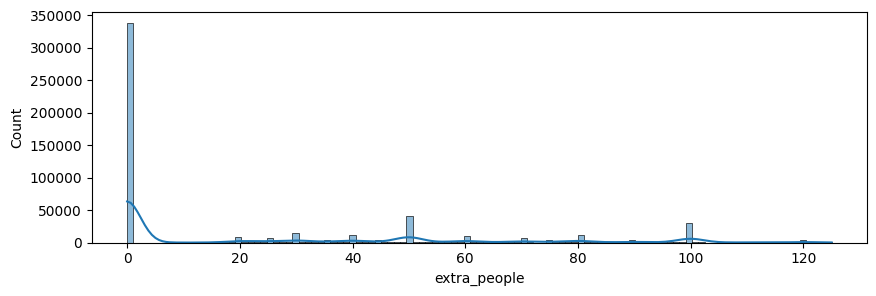

In [11]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas.'.format(linhas_removidas))
histograma(base_airbnb['extra_people'])

In [ ]:
base_airbnb['extra_people'].describe()

count    531084.000000
mean         21.998812
std          33.567440
min           0.000000
25%           0.000000
50%           0.000000
75%          46.000000
max         125.000000
Name: extra_people, dtype: float64

## Análise da coluna Host_listings-count
Essa coluna representa quantos anúncios um mesmo anfitrião tem na plataforma do Airbnb

In [ ]:
base_airbnb['host_listings_count'].describe()

count    531084.000000
mean          8.431743
std          35.603456
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1321.000000
Name: host_listings_count, dtype: float64

(np.float64(-2.0), np.float64(6.0))


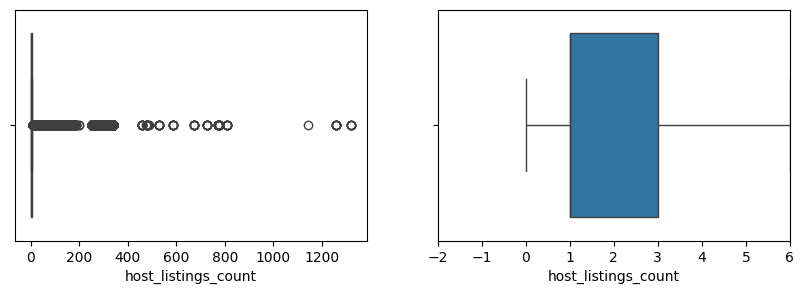

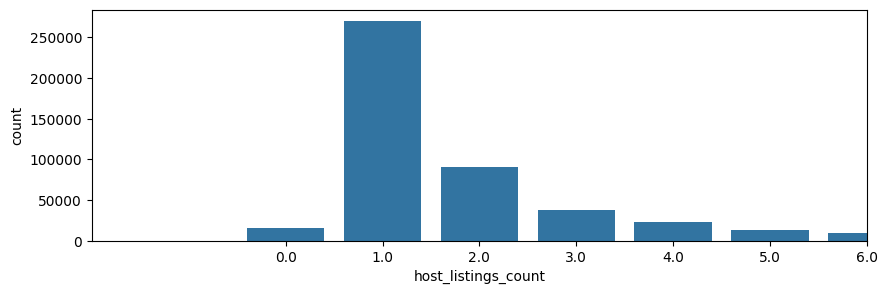

In [ ]:
print(limites(base_airbnb['host_listings_count']))
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

In [ ]:
base_airbnb['host_listings_count'].value_counts()

host_listings_count
1.0      270576
2.0       90712
3.0       37999
4.0       22513
0.0       15721
          ...  
329.0         1
114.0         1
161.0         1
473.0         1
336.0         1
Name: count, Length: 169, dtype: int64

In [12]:
# Podemos exluir os outliers porque parao objetivo do projeto um host com mais de seis imóveis no airbnb não é o publico do sistema. Suponho que esses host sejam imobiliarias ou profissionais que gerenciam imoveis no airbnb.
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas.'.format(linhas_removidas))

70782 linhas removidas.


## Análise da coluna accommodates

In [ ]:
base_airbnb['accommodates'].describe()

count    460419.00000
mean          3.74720
std           2.07509
min           1.00000
25%           2.00000
50%           4.00000
75%           5.00000
max          16.00000
Name: accommodates, dtype: float64

(np.float64(-2.5), np.float64(9.5))


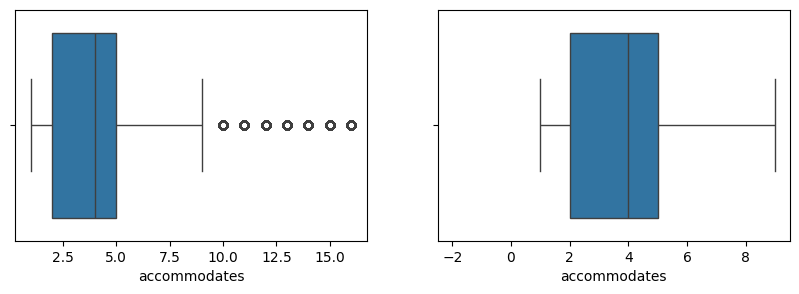

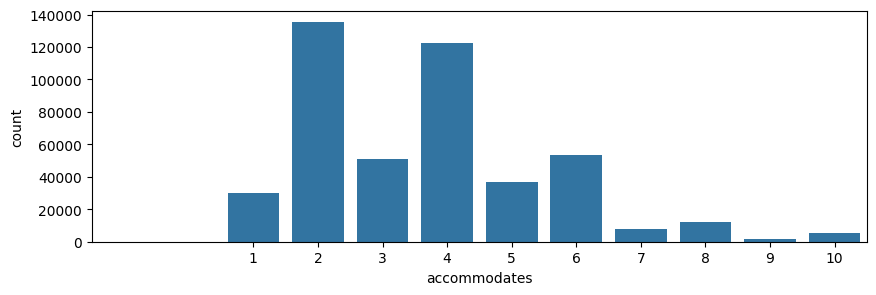

In [ ]:
print(limites(base_airbnb['accommodates']))
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [13]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas.'.format(linhas_removidas))

9282 linhas removidas.


## Análise da coluna bathrooms

In [ ]:
base_airbnb['bathrooms'].describe()

count    451137.000000
mean          1.474758
std           0.706924
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          22.000000
Name: bathrooms, dtype: float64

(np.float64(-0.5), np.float64(3.5))


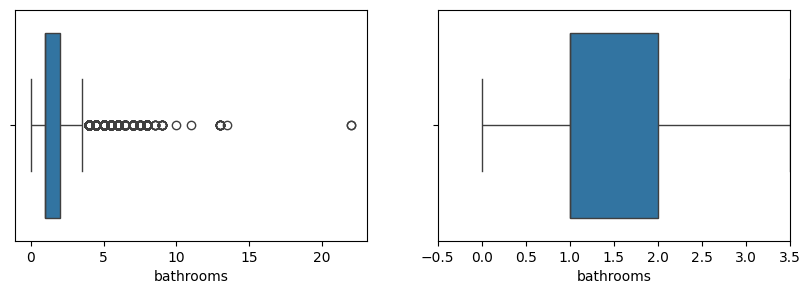

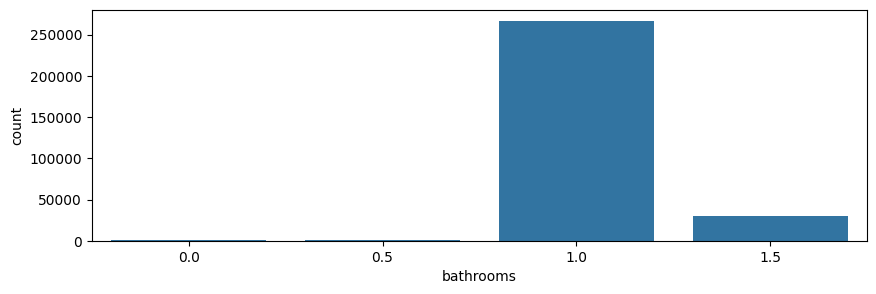

In [ ]:
print(limites(base_airbnb['bathrooms']))
diagrama_caixa(base_airbnb['bathrooms'])
grafico_barra(base_airbnb['bathrooms'])

In [ ]:
base_airbnb['bathrooms'].value_counts()

bathrooms
1.0     266903
2.0     107959
1.5      29578
3.0      23764
2.5      13904
3.5       2935
4.0       2826
0.0        868
4.5        690
5.0        571
0.5        519
8.0        143
6.0        141
5.5        116
7.0        110
6.5         50
7.5         32
13.0         9
9.0          9
8.5          5
22.0         2
13.5         1
10.0         1
11.0         1
Name: count, dtype: int64

In [14]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas.'.format(linhas_removidas))

4707 linhas removidas.


## Análise da coluna bedrooms

In [ ]:
base_airbnb['bedrooms'].describe()

count    446430.000000
mean          1.409047
std           0.788948
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: bedrooms, dtype: float64

(np.float64(-0.5), np.float64(3.5))


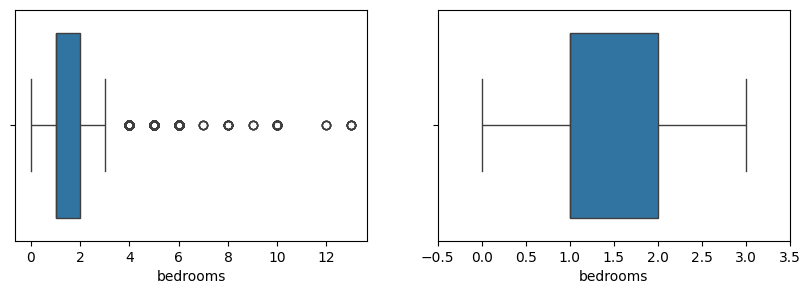

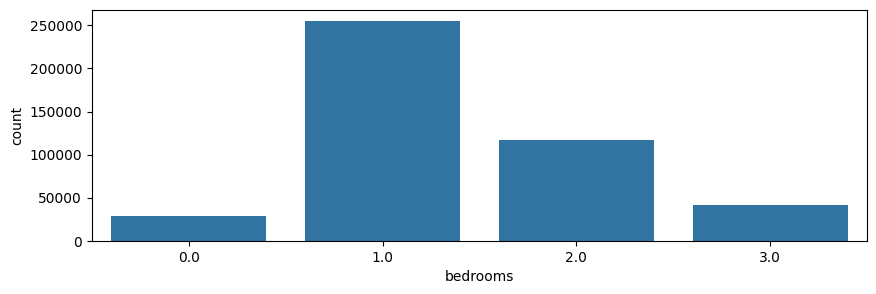

In [ ]:
print(limites(base_airbnb['bedrooms']))
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [15]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas.'.format(linhas_removidas))

3802 linhas removidas.


## Análise da coluna beds

In [ ]:
base_airbnb['beds'].describe()

count    442633.000000
mean          2.161757
std           1.348075
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          25.000000
Name: beds, dtype: float64

In [ ]:
base_airbnb['beds'].value_counts()

beds
1.0     170016
2.0     131679
3.0      73367
4.0      36900
5.0      14881
6.0       8279
0.0       3481
7.0       1819
8.0       1511
9.0        424
10.0       144
11.0        76
14.0        25
12.0        15
16.0        11
17.0         2
25.0         1
15.0         1
18.0         1
Name: count, dtype: int64

(np.float64(-2.0), np.float64(6.0))


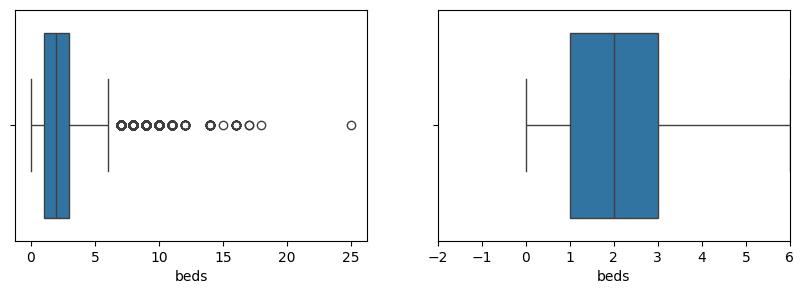

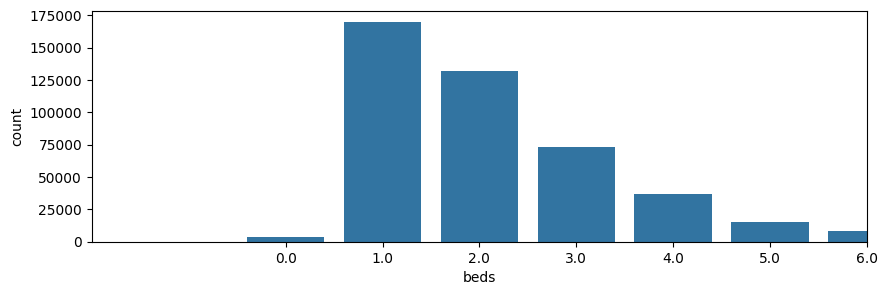

In [ ]:
print(limites(base_airbnb['beds']))
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas.'.format(linhas_removidas))

4030 linhas removidas.


## Análise da coluna guests_included

In [ ]:
base_airbnb['guests_included'].describe()

count    438603.000000
mean          1.480717
std           1.080579
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          16.000000
Name: guests_included, dtype: float64

In [ ]:
base_airbnb['guests_included'].value_counts()

guests_included
1     332377
2      59165
4      24057
3      11244
6       5739
5       4665
7        707
8        420
9         66
16        50
10        47
12        35
15        18
11         8
14         5
Name: count, dtype: int64

(np.float64(1.0), np.float64(1.0))


C:\Users\tamyc\AppData\Local\Temp\ipykernel_1872\1342871851.py:18: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\tamyc\AppData\Local\Temp\ipykernel_1872\1342871851.py:28: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(limites(coluna))


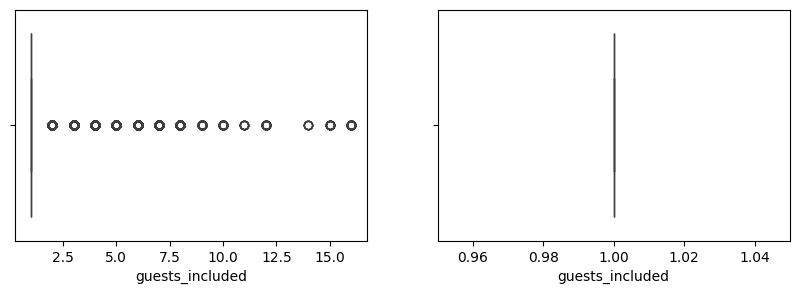

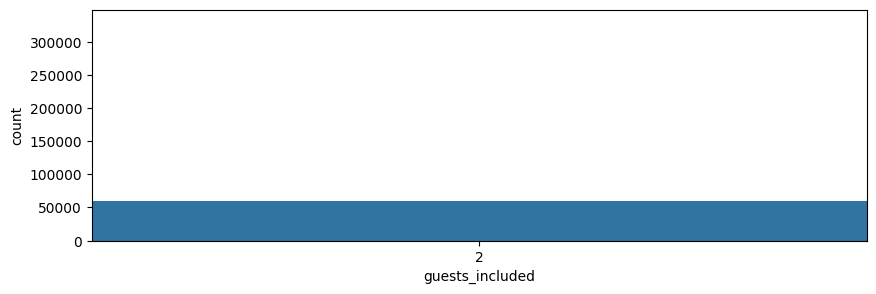

In [ ]:
print(limites(base_airbnb['guests_included']))
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])

In [17]:
# Esses números nao estão apresentando confiabilidade pois não faz sentido que mais da metade da base so permita uma pessoa. Por isso, essa coluna será removida da análise.
base_airbnb = base_airbnb.drop('guests_included', axis=1)

## Análise da coluna minimum_nights

In [ ]:
base_airbnb['minimum_nights'].describe()

count    438603.000000
mean          4.308096
std          19.025632
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1224.000000
Name: minimum_nights, dtype: float64

In [ ]:
base_airbnb['minimum_nights'].value_counts()

minimum_nights
1       127011
2       113872
3        81061
5        34169
4        28497
         ...  
1224         1
250          1
89           1
96           1
222          1
Name: count, Length: 80, dtype: int64

(np.float64(-3.5), np.float64(8.5))


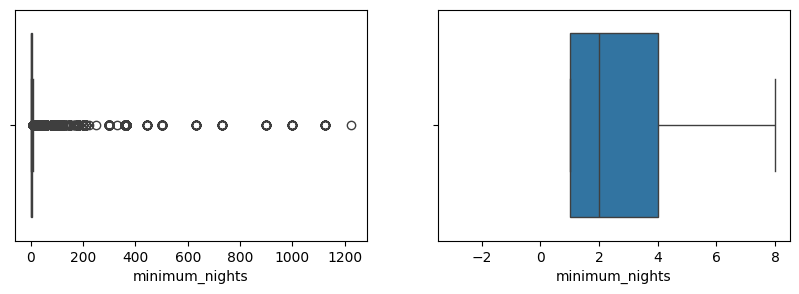

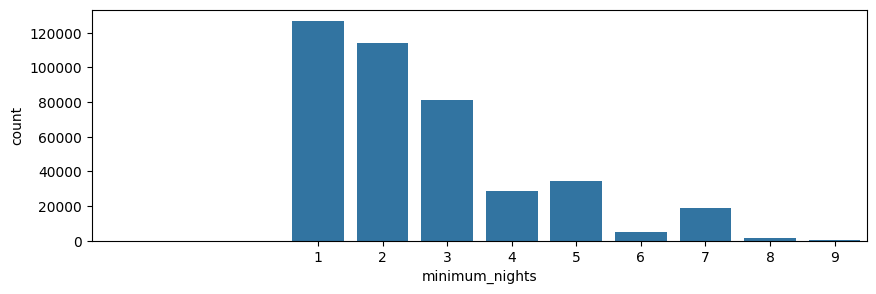

In [ ]:
print(limites(base_airbnb['minimum_nights']))
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [18]:
# A coluna de minimum_nights apresenta uma correlação muito baixa com a coluna price, esses valores são de 0,0.. e 0,00... Essa coluna poderá ser retirada da análise.
# Por enquanto, irei apenas retirar os outliers.
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas.'.format(linhas_removidas))

28625 linhas removidas.


##Análise da coluna maximum_nights

In [ ]:
base_airbnb['maximum_nights'].describe()

count    4.099780e+05
mean     2.504524e+04
std      4.938726e+06
min      1.000000e+00
25%      3.000000e+01
50%      1.125000e+03
75%      1.125000e+03
max      1.000000e+09
Name: maximum_nights, dtype: float64

In [ ]:
base_airbnb['maximum_nights'].value_counts()

maximum_nights
1125    220619
30       45872
90       16790
15       15559
10       13034
         ...  
215          1
183          1
165          1
605          1
373          1
Name: count, Length: 245, dtype: int64

(np.float64(-1612.5), np.float64(2767.5))


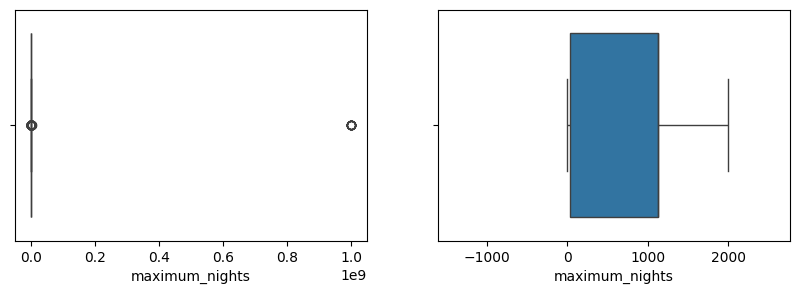

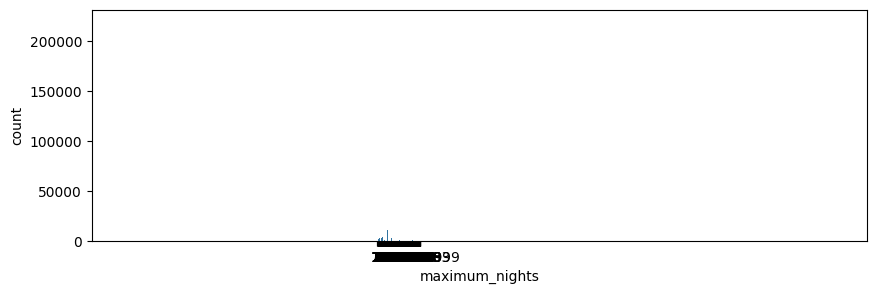

In [ ]:
print(limites(base_airbnb['maximum_nights']))
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [19]:
# A coluna maximum_nights apresenta uma correlação muito baixa com a coluna price, esses valores são de 0,0.. e 0,00... Além disso, os valores parecem aléatórios, Por isso, essa coluna será retirada.
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

In [ ]:
base_airbnb.shape

(409978, 21)

##Análise da coluna number_of_reviews

In [ ]:
base_airbnb['number_of_reviews'].describe()

count    409978.000000
mean          9.817466
std          25.137917
min           0.000000
25%           0.000000
50%           1.000000
75%           7.000000
max         392.000000
Name: number_of_reviews, dtype: float64

In [ ]:
base_airbnb['number_of_reviews'].value_counts()

number_of_reviews
0      158065
1       59431
2       31897
3       21522
4       15692
        ...  
364         1
309         1
322         1
359         1
349         1
Name: count, Length: 363, dtype: int64

(np.float64(-10.5), np.float64(17.5))


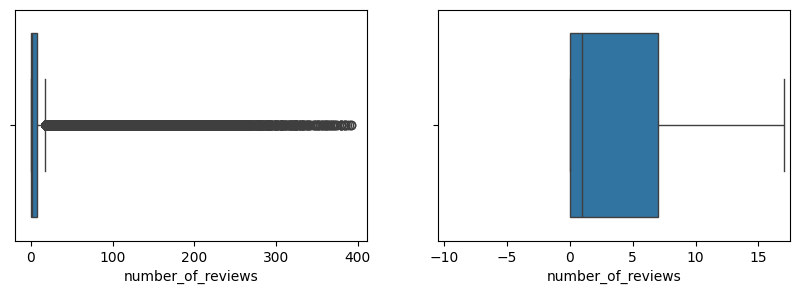

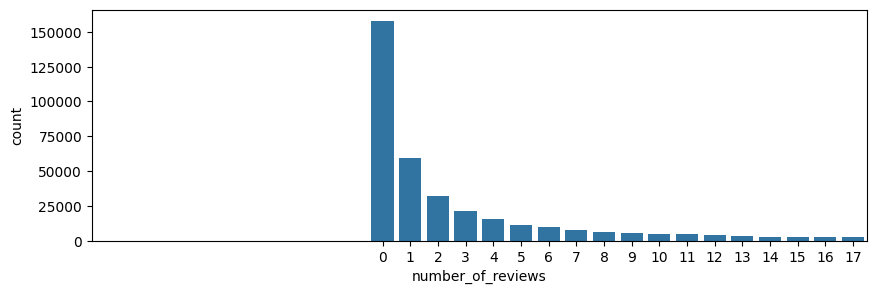

In [ ]:
print(limites(base_airbnb['number_of_reviews']))
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [20]:
# Nesse caso, a princípio, o numero de reviews não tem correlação com a formação do preço do aluguel e sim, com a decisão do usuário de alugar o imóvel ou não. Outra avaliação e de que se o host possui um grande numero de reviews significa que o imovel dele e muito alugado e que o valor cobrado pelo aluguel está correto em relação ao que ele oferece e ao mercado. A principio, deixarei essa coluna após a criação da ML avaliarei se essa coluna continuara ou não.base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(410006, 20)

##Análise da coluna property_type

In [ ]:
print(base_airbnb['property_type'].value_counts())

property_type
Apartment                 320255
House                      35873
Condominium                21384
Serviced apartment          9199
Loft                        9046
Guest suite                 2775
Bed and breakfast           2108
Hostel                      1603
Guesthouse                  1576
Other                       1193
Villa                        913
Townhouse                    692
Aparthotel                   462
Tiny house                   417
Earth house                  368
Chalet                       352
Hotel                        309
Boutique hotel               308
Casa particular (Cuba)       219
Cottage                      184
Bungalow                     161
Cabin                        104
Nature lodge                  94
Treehouse                     55
Island                        46
Boat                          42
Castle                        36
Hut                           30
Campsite                      28
Dorm                         

In [21]:
# Todos os tipos de imoveis abaixo de 100 serão classificados como Other

tabela_tipos_imovel = base_airbnb['property_type'].value_counts()
colunas_agrupadas = []

for tipo in tabela_tipos_imovel.index:
    if tabela_tipos_imovel[tipo] <= 2800:
        colunas_agrupadas.append(tipo)
#print(colunas_agrupadas)
for tipo in colunas_agrupadas:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Other'

In [ ]:
print(base_airbnb['property_type'].value_counts())

property_type
Apartment             320255
House                  35873
Condominium            21384
Other                  14221
Serviced apartment      9199
Loft                    9046
Name: count, dtype: int64


##Análise da coluna room_type

room_type
Entire home/apt    264258
Private room       136621
Shared room          8132
Hotel room            967
Name: count, dtype: int64


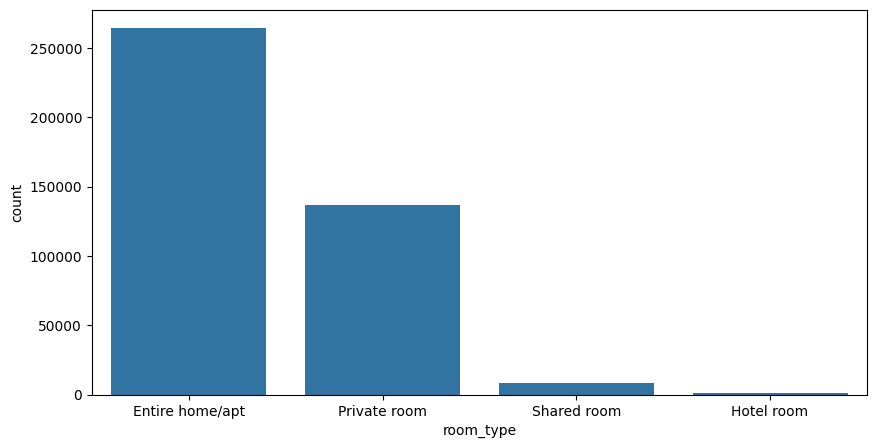

In [ ]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='room_type', data=base_airbnb)

Em tipo de quarto, não precisamos fazer nada, ele já parece estar bem distribuído

## Análise da coluna bed_type

bed_type
Real Bed         402588
Pull-out Sofa      5279
Futon              1045
Airbed              744
Couch               322
Name: count, dtype: int64


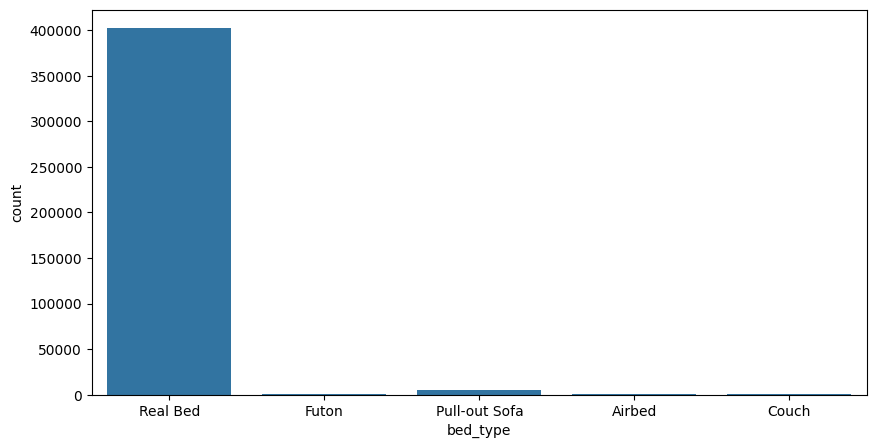

In [ ]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)

In [22]:
# Agrupamentos de outros tipo de cama

tabela_tipos_cama = base_airbnb['bed_type'].value_counts()
colunas_agrupadas = []

for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] <= 10000:
        colunas_agrupadas.append(tipo)
#print(colunas_agrupadas)
for tipo in colunas_agrupadas:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Other_bed'

bed_type
Real Bed     402588
Other_bed      7390
Name: count, dtype: int64


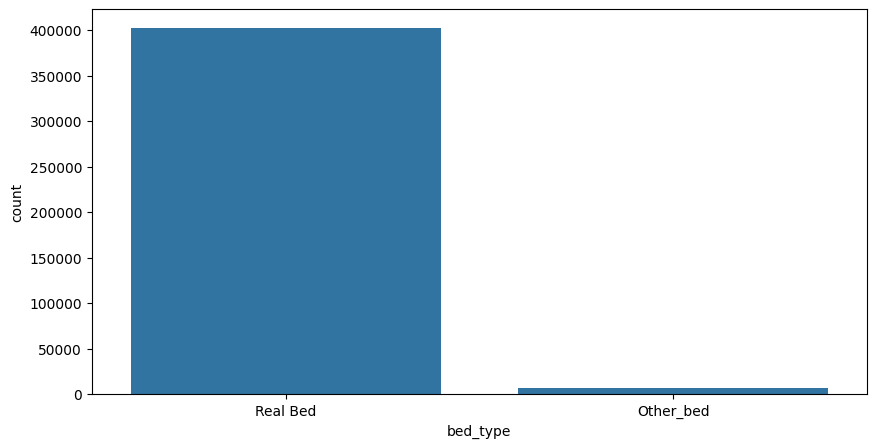

In [ ]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='bed_type', data=base_airbnb)

## Análise da coluna cancellation_policy

cancellation_policy
flexible                       180340
strict_14_with_grace_period    148684
moderate                        80786
super_strict_60                   125
strict                             23
super_strict_30                    20
Name: count, dtype: int64


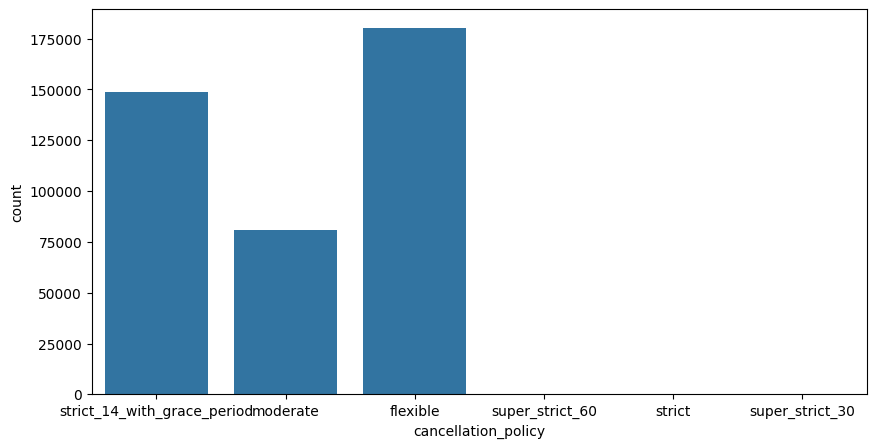

In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)

cancellation_policy
flexible                       180340
strict_14_with_grace_period    148684
moderate                        80786
super_strict_60                   125
strict                             23
super_strict_30                    20
Name: count, dtype: int64


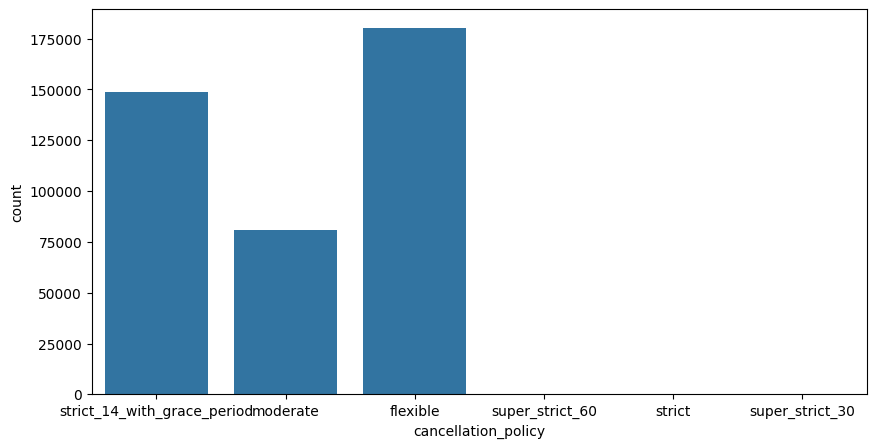

In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot(x='cancellation_policy', data=base_airbnb)

In [23]:
# Agrupando strict, super_strict_30 e super_strict_60

tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

['super_strict_60', 'strict', 'super_strict_30']


In [ ]:
print(base_airbnb['cancellation_policy'].value_counts())

cancellation_policy
flexible                       180340
strict_14_with_grace_period    148684
moderate                        80786
strict                            168
Name: count, dtype: int64


## Análise da coluna amenities

In [ ]:
print(base_airbnb['amenities'].value_counts())

amenities
{}                                                                                                                                   3745
{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom",Washer}                           209
{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom","Family/kid friendly",Washer}     157
{"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                           142
{"Smoking allowed","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                         131
                                                                                                                                     ... 
{TV,Wifi,"Air conditioning",Kitchen,Elevator,"Fire extinguisher",Essentials,Hangers,"Hair dryer","Hot water"}                           1
{Wifi,Kitchen,Washer,Ess

In [24]:
# Como essa coluna apresenta uma listas de comididades de cada imovel, e não possui um padrão. Para avlaiar essa coluna, irei contar quantas comodidades o imovel possui para avaliar se vai agregar no modelo.

print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


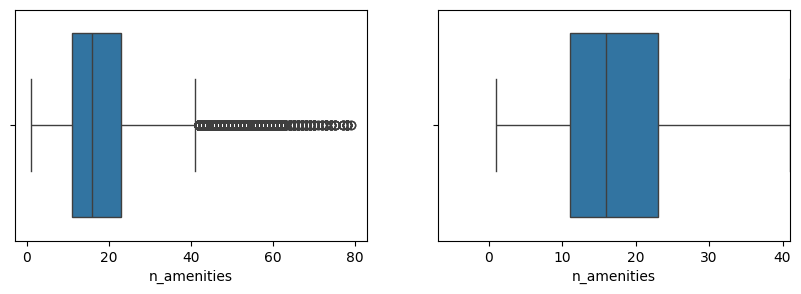

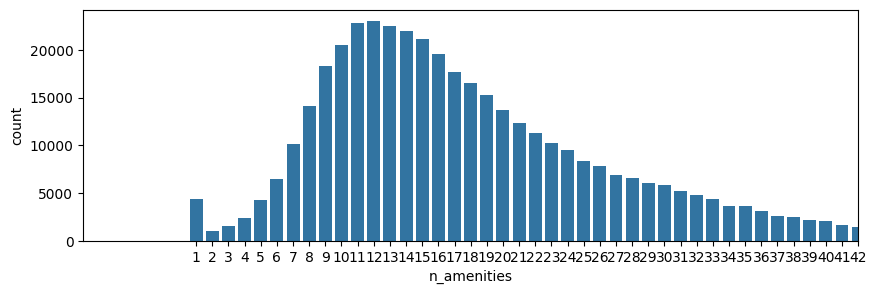

In [ ]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [25]:
# Retirando a coluna amenities
base_airbnb = base_airbnb.drop('amenities',axis=1 )

## Análise da coluna latitude e longitude

In [ ]:
# https://plotly.com/python/mapbox-to-maplibre/

# Amostra aleatória
amostra = base_airbnb.sample(n=50000, random_state=42)

# Centro do mapa
centro_mapa = {
    'lat': amostra['latitude'].mean(),
    'lon': amostra['longitude'].mean()
}

# Novo mapa com plotly express density_map (MapLibre)
mapa = px.density_map(
    amostra,
    lat='latitude',
    lon='longitude',
    z='price',
    radius=5,
    center=centro_mapa,
    zoom=10,
    map_style='carto-positron',  # equivalente ao stamen-terrain
    title="Mapa de Densidade de Preços do Airbnb"
)

mapa.show()


## Encoding

In [26]:
# Cria uma copia para realizar o encoding
base_airbnb_encoded = base_airbnb.copy()
display(base_airbnb_encoded.info())
display(base_airbnb_encoded.head())
base_airbnb_encoded.shape



<class 'pandas.core.frame.DataFrame'>
Index: 410006 entries, 0 to 639873
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         410006 non-null  object 
 1   host_listings_count       410006 non-null  float32
 2   latitude                  410006 non-null  float32
 3   longitude                 410006 non-null  float32
 4   property_type             410006 non-null  object 
 5   room_type                 410006 non-null  object 
 6   accommodates              410006 non-null  int32  
 7   bathrooms                 410006 non-null  float32
 8   bedrooms                  410006 non-null  float32
 9   beds                      410006 non-null  float32
 10  bed_type                  410006 non-null  object 
 11  price                     410006 non-null  float32
 12  extra_people              410006 non-null  float32
 13  minimum_nights            410006 non-null  int32 

None

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes,n_amenities
0,f,2.0,-22.965919,-43.178959,Condominium,Entire home/apt,5,1.0,2.0,2.0,Real Bed,302.0,58.0,5,t,f,strict_14_with_grace_period,2019,4,25
1,f,3.0,-22.977119,-43.190449,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,159.0,45.0,4,f,f,strict_14_with_grace_period,2019,4,14
2,t,1.0,-22.983021,-43.214272,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,252.0,39.0,2,t,f,strict_14_with_grace_period,2019,4,17
3,t,1.0,-22.988159,-43.193588,Apartment,Entire home/apt,3,1.5,1.0,2.0,Real Bed,350.0,58.0,2,f,f,strict_14_with_grace_period,2019,4,31
4,t,1.0,-22.981270,-43.190460,Loft,Entire home/apt,2,1.0,1.0,2.0,Real Bed,221.0,80.0,3,t,f,strict_14_with_grace_period,2019,4,35


(410006, 20)

In [28]:
# Colunas com valores True ou False, vamos substituir True por 1 e False por 0.
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

for coluna in colunas_tf:
    base_airbnb.loc[base_airbnb_encoded[coluna]=='t', coluna] = 1
    base_airbnb.loc[base_airbnb_encoded[coluna]=='f', coluna] = 0

In [29]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

# Faz o encoding de todas as colunas categóricas de uma vez
base_airbnb_encoded = pd.get_dummies(base_airbnb, columns=colunas_categorias, drop_first=False)

# Agora faça o mapeamento das strings booleanas, etc.
mapa_binario = {'t': 1, 'f': 0, 'yes': 1, 'no': 0, 'True': 1, 'False': 0}

for col in base_airbnb_encoded.columns:
    if base_airbnb_encoded[col].dtype == 'object':
        base_airbnb_encoded[col] = base_airbnb_encoded[col].map(mapa_binario).fillna(base_airbnb_encoded[col])

# Converte booleanos para int32
for col in base_airbnb_encoded.select_dtypes(include='bool').columns:
    base_airbnb_encoded[col] = base_airbnb_encoded[col].astype('int32')

# Substitui NaN por 0
base_airbnb_encoded = base_airbnb_encoded.fillna(0)

# Converte float64 para float32 e int64 para int32
for col in base_airbnb_encoded.columns:
    if base_airbnb_encoded[col].dtype == 'float64':
        base_airbnb_encoded[col] = base_airbnb_encoded[col].astype('float32')
    elif base_airbnb_encoded[col].dtype == 'int64':
        base_airbnb_encoded[col] = base_airbnb_encoded[col].astype('int32')

display(base_airbnb_encoded.info())
display(base_airbnb_encoded.head())
base_airbnb_encoded.shape



<class 'pandas.core.frame.DataFrame'>
Index: 410006 entries, 0 to 639873
Data columns (total 32 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   host_is_superhost                                410006 non-null  int32  
 1   host_listings_count                              410006 non-null  float32
 2   latitude                                         410006 non-null  float32
 3   longitude                                        410006 non-null  float32
 4   accommodates                                     410006 non-null  int32  
 5   bathrooms                                        410006 non-null  float32
 6   bedrooms                                         410006 non-null  float32
 7   beds                                             410006 non-null  float32
 8   price                                            410006 non-null  float32
 9   extra_people        

None

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Other_bed,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,0,2.0,-22.965919,-43.178959,5,1.0,2.0,2.0,302.0,58.0,...,1,0,0,0,0,1,0,0,0,1
1,0,3.0,-22.977119,-43.190449,3,1.0,1.0,2.0,159.0,45.0,...,1,0,0,0,0,1,0,0,0,1
2,1,1.0,-22.983021,-43.214272,3,1.0,1.0,2.0,252.0,39.0,...,1,0,0,0,0,1,0,0,0,1
3,1,1.0,-22.988159,-43.193588,3,1.5,1.0,2.0,350.0,58.0,...,1,0,0,0,0,1,0,0,0,1
4,1,1.0,-22.981270,-43.190460,2,1.0,1.0,2.0,221.0,80.0,...,1,0,0,0,0,1,0,0,0,1


(410006, 32)

### Modelo de Previsão
- Métricas de Avaliação

Vamos usar aqui o R² que vai nos dizer o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo.
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando.
-> Quanto menor for o erro, melhor

In [30]:
# Função de avaliação para todos os modelos
def avaliar_modelo(nome_modelo, modelo, X_train, y_train, X_test, y_test):
    inicio = time.time()
    modelo.fit(X_train, y_train)
    fim = time.time()

    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print(f"\n--- Avaliação do Modelo: {nome_modelo} ---")
    print(f"Tempo de execução: {fim - inicio:.2f} segundos")
    print(f"\n--- Desempenho no TREINO ---")
    print(f"R² (Treino): {r2_score(y_train, y_pred_train) * 100:.2f}%")
    print(f"RMSE (Treino): {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

    print(f"\n--- Desempenho no TESTE ---")
    print(f"R² (Teste): {r2_score(y_test, y_pred_test) * 100:.2f}%")
    print(f"RMSE (Teste): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")

- Escolha dos Modelos a Serem Testados
    1. RandomForestRegressor
    2. LinearRegression
    3. Extra Tree
    4. GradientBoostingRegressor
    5. XGBoost
    6. LightGBM
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou até centenas de modelos diferentes. A medida com que você for aprendendo mais e mais sobre Ciência de Dados, você vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situação.

Mas na dúvida, esses 3 modelos que usamos aqui são bem bons para muitos problemas de Regressão.

In [31]:
# Cria dataframe para teste dos modelos
base_airbnb_modelo = base_airbnb_encoded.copy()

# Separa x e y
y = base_airbnb_modelo['price']
X = base_airbnb_modelo.drop('price', axis=1)

# Separação da Bases de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

## 1. RandomForestRegressor

In [ ]:
# Executando o modelo RandonForest
modelo_rf = RandomForestRegressor()
avaliar_modelo("RandomForestRegressor", modelo_rf, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: RandomForestRegressor ---
Tempo de execução: 476.61 segundos

--- Desempenho no TREINO ---
R² (Treino): 99.42%
RMSE (Treino): 19.97

--- Desempenho no TESTE ---
R² (Teste): 95.95%
RMSE (Teste): 52.83


**Métrica	Treino	Teste**
**R²	    99.42%	95.95%**
**RMSE	19.97	52.83**
**Tempo Execução	~477 segundos**

Pontos positivos:
- Alto R² no teste (95.95%) → O modelo consegue explicar quase 96% da variância dos dados de teste.
- Baixo RMSE no teste (52.83) → O erro médio é relativamente baixo, o que mostra boa capacidade preditiva.
- Melhor desempenho entre os modelos testados até agora, inclusive superando XGBoost e LightGBM.
Pontos negativos:
- O R² no treino está altíssimo (99.42%), quase perfeito.
- O RMSE no treino é muito menor que no teste (19.97 vs 52.83).
- Esse gap entre treino e teste indica que o modelo pode estar memorizar os dados de treino em vez de generalizar para novos dados.


## 2. LinearRegression

In [ ]:
# Executando o modelo LinearRegression
modelo_lr = LinearRegression()
avaliar_modelo("LinearRegression", modelo_lr, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: LinearRegression ---
Tempo de execução: 1.55 segundos

--- Desempenho no TREINO ---
R² (Treino): 32.04%
RMSE (Treino): 215.57

--- Desempenho no TESTE ---
R² (Teste): 31.97%
RMSE (Teste): 216.46


In [ ]:
O desempenho do LinearREgression foi bem inferior ao esperado.

## 3. ExtraTreeRegressor

In [32]:
# Executando o modelo ExtraTreesRegressor
modelo_et = ExtraTreesRegressor()
avaliar_modelo("ExtraTreesRegressor", modelo_et, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: ExtraTreesRegressor ---
Tempo de execução: 276.44 segundos

--- Desempenho no TREINO ---
R² (Treino): 100.00%
RMSE (Treino): 0.09

--- Desempenho no TESTE ---
R² (Teste): 96.31%
RMSE (Teste): 50.42


**Métrica	Treino	Teste**
**R²	    100.00%	96.31%**
**RMSE	0.09	50.42**
**Tempo Execução	~276 segundos**

Ponto Positivos:
- R² no teste (96.31%): Excelente! Explica mais de 96% da variância dos dados não vistos.
- RMSE no teste (50.42): Melhor que o RandomForest anterior (52.83), então o erro de previsão caiu.
- Tempo de execução menor que o RandomForest padrão (~276s vs ~477s).

Pontos Negativos:
- Sinais críticos de Overfitting
- R² no treino = 100% e RMSE = 0.09 → O modelo memoriza os dados de treino quase perfeitamente.
- Gap muito grande entre treino e teste, mesmo com bom R² no teste.

In [48]:
# Teste do modelo redefinido
modelo_et_redefinido = ExtraTreesRegressor(
    n_estimators=200,       # Pode manter ou até diminuir um pouco
    max_depth=20,           # <<< MUITO IMPORTANTE
    min_samples_leaf=5,    # <<< MUITO IMPORTANTE
    n_jobs=-1,              # Para usar todos os processadores
    random_state=42         # Para reprodutibilidade
)

avaliar_modelo("ExtraTreesRegressor", modelo_et_redefinido, X_train, y_train, X_test, y_test)



--- Avaliação do Modelo: ExtraTreesRegressor ---
Tempo de execução: 194.33 segundos

--- Desempenho no TREINO ---
R² (Treino): 84.75%
RMSE (Treino): 102.13

--- Desempenho no TESTE ---
R² (Teste): 81.62%
RMSE (Teste): 112.50


In [ ]:
Análise dos Resultados

Resultado Anterior (Overfitting):
**-R² Treino: 100%**
**-R² Teste: 96.29%**

Resultado Atual (Regularizado):
**-R² Treino: 84.75%**
**-R² Teste: 81.62%**

Diferença: 3.13%

O Ponto Positivo: Overfitting Resolvido
A diferença entre o desempenho no treino e no teste agora é pequena (apenas 3.13%). Isso mostra que o seu modelo regularizado é robusto e generaliza bem o que aprendeu para dados novos. O modelo não está mais "memorizando" o treino.

O overfiting acabou porém, podemos melhorar o desempenho.

## 4. GradientBoostingRegressor

In [ ]:
# Executando o modelo GradientBoostingRegressor
modelo_gb = GradientBoostingRegressor()
avaliar_modelo("GradientBoostingRegressor", modelo_gb, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: GradientBoostingRegressor ---
Tempo de execução: 84.37 segundos

--- Desempenho no TREINO ---
R² (Treino): 41.90%
RMSE (Treino): 199.32

--- Desempenho no TESTE ---
R² (Teste): 41.61%
RMSE (Teste): 200.55


Métrica	Treino	Teste	Análise
**R²	41.90%	41.61%	Ruim (baixa explicação da variância)**
**RMSE	199.32	200.55	Erro alto**
**Tempo	84.37 segundos	—	Razoável, mas não justifica o desempenho**

Pontos Positivos:
- Desempenho bom mas não justifica.

Pontos Negativos:
- O modelo está subajustado (underfitting):
- R² abaixo de 50% indica que ele não está capturando bem os padrões nos dados.
- Isso vale tanto no treino quanto no teste — ou seja, ele está com baixa capacidade preditiva geral.
- O RMSE está muito alto (200), pior que os outros modelos que você testou (por exemplo, ExtraTrees com RMSE de 50–110).

In [49]:
# Refinando os parâmetros para buscar um desempenho melhor
modelo_gb_redefinido = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_leaf=3,
    random_state=42
)
avaliar_modelo("GradientBoostingRegressor", modelo_gb_redefinido, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: GradientBoostingRegressor ---
Tempo de execução: 241.07 segundos

--- Desempenho no TREINO ---
R² (Treino): 51.33%
RMSE (Treino): 182.44

--- Desempenho no TESTE ---
R² (Teste): 50.18%
RMSE (Teste): 185.25


Métrica	        Modelo Redefinido	Primeiro Modelo
**Tempo Execução	241.07 s	    84.37 s**
**R² (Treino)	    51.33%	        41.90%**
**RMSE (Treino)	    182.44          199.32**
**R² (Teste)	    50.18%	        41.61%**
**RMSE (Teste)	    185.25	        200.55**

Pontos Positivos:
- Desempenho melhor
- Generalização mais forte, pois melhora tanto o treino quanto o teste.

Pontos negativos:
- Tanto o erro quanto a capacidade de explicação do modelo são mais baixos.
- Pode ter sofrido de underfitting: o modelo está muito simples para capturar os padrões dos dados.

Ainda não é um bom modelo para ser trabalhado.


## 5. XGBRegressor  

In [ ]:
# Exeutando o modelo XGRegressor
modelo_xgb = XGBRegressor()
avaliar_modelo("XGBoost", modelo_xgb, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: XGBoost ---
Tempo de execução: 3.54 segundos

--- Desempenho no TREINO ---
R² (Treino): 59.71%
RMSE (Treino): 165.98

--- Desempenho no TESTE ---
R² (Teste): 57.75%
RMSE (Teste): 170.58


Métrica	Treino	Teste	Análise
**R²	    59.71%	57.75%	Regular, com espaço para melhoria**
**RMSE	165.98	170.58	Erro ainda alto**
**Tempo exec.	⏱️ 3.54s	—	Excelente! Muito rápido**

Pontos positivos:
- Sem overfitting: diferença pequena entre treino e teste.
- Boa generalização para um modelo simples e leve.
- Execução extremamente rápida, ideal para iteração e tuning.
- Melhor que GradientBoostingRegressor (que teve ~50% R² e RMSE > 180).

Pontos Negativos:
- Ainda não competitivo com seus melhores modelos:
- ExtraTrees e RandomForest tiveram R² > 95% e RMSE < 60.
- Provavelmente está subajustado:
- Parâmetros atuais não permitem à árvore aprender padrões mais profundos ou complexos.


In [ ]:
# Refinando os parâmetros para buscar um desempenho melhor
modelo_xgb_redefinido = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=9,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=1,              # ajuda a evitar overfitting
    reg_alpha=0.1,        # L1 regularization
    reg_lambda=1,         # L2 regularization
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", modelo_xgb_redefinido, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: XGBoost ---
Tempo de execução: 36.63 segundos

--- Desempenho no TREINO ---
R² (Treino): 79.74%
RMSE (Treino): 117.71

--- Desempenho no TESTE ---
R² (Teste): 76.58%
RMSE (Teste): 127.01


In [56]:
# Definindo o modelo base
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

# Espaço de busca
param_distributions = {
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [5, 7, 9],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

# Busca com validação cruzada
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    scoring='r2',
    n_iter=25,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Executa a busca
# avaliar_modelo("XGBoost", v, X_train, y_train, X_test, y_test)
random_search.fit(X_train, y_train)

# Melhor modelo
print("Melhores parâmetros:", random_search.best_params_)
melhor_xgb = random_search.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Melhores parâmetros: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}


In [ ]:
# MELHOR MODELO!

melhor_xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", melhor_xgb, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: XGBoost ---
Tempo de execução: 34.78 segundos

--- Desempenho no TREINO ---
R² (Treino): 88.09%
RMSE (Treino): 90.26

--- Desempenho no TESTE ---
R² (Teste): 84.67%
RMSE (Teste): 102.76


#   **----MELHOR MODELO-----**

Métrica	Treino	Teste
**R²	88.09%	84.67%**
**RMSE	90.26	102.76**
**Gap de R²	~3.4 p.p.	🔹 Pequeno**

Pontos Positivos:
- Alta performance geral: R² de 84.67% no teste mostra que o modelo explica bem a variabilidade dos preços.
- Erro absoluto moderado: RMSE de ~102 indica que, em média, o modelo erra o preço em ~R$102 — o que pode ser aceitável dependendo da escala do valor (price).
- Pouco overfitting: A diferença entre treino e teste é pequena — ou seja, o modelo generaliza bem.

## 6. LightGBM 

In [40]:
# 6. LightGBM
modelo_lgb = LGBMRegressor()

# Avaliar todos
avaliar_modelo("LightGBM", modelo_lgb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 798
[LightGBM] [Info] Number of data points in the train set: 307504, number of used features: 30
[LightGBM] [Info] Start training from score 319.407435

--- Avaliação do Modelo: LightGBM ---
Tempo de execução: 5.87 segundos

--- Desempenho no TREINO ---
R² (Treino): 50.03%
RMSE (Treino): 184.86

--- Desempenho no TESTE ---
R² (Teste): 49.20%
RMSE (Teste): 187.05


In [41]:
modelo_lgb = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=9,
    num_leaves=64,           # mais flexível
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

avaliar_modelo("LightGBM", modelo_lgb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 307504, number of used features: 30
[LightGBM] [Info] Start training from score 319.407435

--- Avaliação do Modelo: LightGBM ---
Tempo de execução: 15.34 segundos

--- Desempenho no TREINO ---
R² (Treino): 61.73%
RMSE (Treino): 161.76

--- Desempenho no TESTE ---
R² (Teste): 59.77%
RMSE (Teste): 166.45


## ** Comparação entre os modelos**

Modelo	                    R² (Treino) RMSE (Treino)	R² (Teste)	RMSE (Teste)	Tempo (s)	Overfitting
**XGBoost (otimizado)	        88.09%	    90.26	        84.67%	    102.76	        34.78	    Baixo**
RandomForestRegressor	    99.42%	    19.97	        95.95%	    52.83	        476.61	    Moderado
ExtraTrees              	84.75%	    102.13	        81.62%	    112.50	        188.51	    Baixo
LightGBM                    61.73%	    161.76	        59.77%	    166.45	        15.34	    Baixo
GradientBoosting        	51.33%	    182.44	        50.18%	    185.25	        241.07	    Baixo

### Análise do Melhor Modelo

In [40]:
# Avaliando a importancia de cada uma das features no model0

# Seus dados originais
importancias = modelo_et.feature_importances_
nomes_colunas = X_train.columns

# Criando uma Série no Pandas com as importâncias
importancia_features_df = pd.Series(importancias, index=nomes_colunas)

# Ordenando da mais importante para a menos importante
importancia_features_df = importancia_features_df.sort_values(ascending=False)

# Imprimindo o resultado formatado
for coluna, importancia in importancia_features_df.items():
    print(f"{coluna:<25} {importancia:.2%}") # '<25' alinha o texto à esquerda


bedrooms                  11.17%
latitude                  10.36%
longitude                 10.13%
extra_people              8.97%
n_amenities               8.78%
accommodates              7.44%
bathrooms                 6.79%
minimum_nights            6.69%
room_type_Entire home/apt 6.06%
beds                      5.22%
host_listings_count       4.23%
instant_bookable          2.22%
cancellation_policy_flexible 1.79%
host_is_superhost         1.64%
property_type_Apartment   1.32%
cancellation_policy_strict_14_with_grace_period 1.24%
cancellation_policy_moderate 1.04%
ano                       0.97%
property_type_House       0.72%
property_type_Condominium 0.59%
mes                       0.56%
room_type_Private room    0.40%
property_type_Other       0.37%
property_type_Serviced apartment 0.28%
bed_type_Other_bed        0.26%
bed_type_Real Bed         0.25%
property_type_Loft        0.24%
room_type_Shared room     0.19%
room_type_Hotel room      0.04%
cancellation_policy_strict 0.04%
i

##Análise das features

**Variáveis mais importantes (acima de 8%)**
Variável	    Importância (%)	Interpretação
bedrooms	    10.96%	    O número de quartos é o fator mais relevante. Indica forte correlação com a capacidade, conforto e preço da acomodação.
latitude	    10.38%	    Localização geográfica tem papel central na precificação. Regiões mais valorizadas geram preços maiores.
longitude	    10.08%	    Complementa a latitude para determinar a exata localização do imóvel.
n_amenities	    8.82%	    Número de comodidades disponíveis afeta a atratividade e valor percebido.
extra_people	8.73%	    Política de preço por hóspedes extras influencia bastante o valor final.

**Essas 5 variáveis respondem por cerca de 49% da importância total do modelo, com ênfase clara em localização, estrutura física e políticas de hospedagem.**

**Importância moderada (entre 5% e 8%)**
Variável	                Importância (%)	Interpretação
accommodates	            7.31%	        Capacidade de hóspedes também tem forte impacto. Naturalmente ligada a bedrooms e beds.
bathrooms	                6.95%	        Mais banheiros agregam conforto, principalmente para grupos.
minimum_nights	            6.69%	        Regras de estadia mínima podem afastar ou atrair certos perfis.
room_type_Entire home/apt	6.35%	        Oferecer o imóvel inteiro é altamente valorizado pelos usuários.
beds	                    5.26%	        Quantidade de camas é importante, mas menos que bedrooms e accommodates.

**Essas variáveis reforçam a lógica de que capacidade, conforto e flexibilidade são grandes impulsionadores de valor.**

**Importância baixa (entre 1% e 5%)**
Variável	                                    Importância (%)	Interpretação
host_listings_count	                            4.23%	    Hosts com muitos imóveis podem adotar estratégias de preço diferenciadas.
instant_bookable	                            2.25%	    Facilidade de reserva tem influência moderada.
cancellation_policy_flexible	                1.79%	    Políticas mais flexíveis podem tornar o imóvel mais atraente.
host_is_superhost	                            1.68%	    Ser um superhost tem leve influência no modelo.
property_type_Apartment	                        1.31%	    Tipo do imóvel afeta o valor, mas não é o mais determinante.
cancellation_policy_strict_14_with_grace_period	1.25%	    Políticas rígidas tendem a afastar hóspedes, o que reduz atratividade.
cancellation_policy_moderate	                1.05%	    Parecido com o anterior. Baixa influência.

**Aqui entram características mais subjetivas e relacionadas à experiência do hóspede.**

**Importância muito baixa (abaixo de 1%)**
Variável	                                                Importância (%)	Observação
ano, mes	                                                0.98%, 0.55%	Sazonalidade e variação ao longo do tempo têm influência pequena.
property_type_House, Condominium, Other, Serviced apartment	0.72% a 0.30%	Diferenciação por tipo de imóvel tem pouco peso.
room_type_Private room	                                    0.37%	        Menos valorizado que aluguel de imóvel inteiro.
bed_type_Real Bed	                                        0.26%	        Tipo de cama não influencia muito.
room_type_Shared room	                                    0.19%	        Quase irrelevante — poucos anúncios assim?
room_type_Hotel room	                                    0.04%	        Muito rara ou irrelevante para o modelo.
cancellation_policy_strict	                                0.03%	        Peso insignificante.
is_business_travel_ready	                                0.00%	        Sem qualquer influência. Provavelmente muitos valores nulos ou sem variação.

#**Conclusão**
=> Fatores mais determinantes:
Características físicas do imóvel (quartos, localização, banheiros, camas, amenities)

Capacidade de hóspedes e regras de acomodação

=> Fatores pouco ou nada relevantes:
Tipos específicos de propriedade

Políticas de cancelamento mais rígidas

Indicadores como "pronto para viagem a negócios" ou room_type_Hotel room

=> O que isso mostra?
O modelo está fortemente centrado no que é visivelmente útil e mensurável para o hóspede: localização, tamanho, conforto. Já aspectos mais "comportamentais" (como ser superhost ou política de cancelamento) têm pouco impacto preditivo no modelo.



### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [ ]:
# Criar uma copia da base para reaizar os testes com segurança
base_airbnb_ajustes = base_airbnb_modelo.copy()

# Exclusão da coluna is_business_travel_ready
base_airbnb_ajustes = base_airbnb_ajustes.drop('is_business_travel_ready', axis=1)

In [66]:
display(base_airbnb_ajustes.columns)
display(base_airbnb_ajustes.info())
display(base_airbnb_ajustes.head())
base_airbnb_ajustes.shape


Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment', 'property_type_Condominium',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Other_bed', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 410006 entries, 0 to 639873
Data columns (total 31 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   host_is_superhost                                410006 non-null  int32  
 1   host_listings_count                              410006 non-null  float32
 2   latitude                                         410006 non-null  float32
 3   longitude                                        410006 non-null  float32
 4   accommodates                                     410006 non-null  int32  
 5   bathrooms                                        410006 non-null  float32
 6   bedrooms                                         410006 non-null  float32
 7   beds                                             410006 non-null  float32
 8   price                                            410006 non-null  float32
 9   extra_people        

None

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Other_bed,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,0,2.0,-22.965919,-43.178959,5,1.0,2.0,2.0,302.0,58.0,...,1,0,0,0,0,1,0,0,0,1
1,0,3.0,-22.977119,-43.190449,3,1.0,1.0,2.0,159.0,45.0,...,1,0,0,0,0,1,0,0,0,1
2,1,1.0,-22.983021,-43.214272,3,1.0,1.0,2.0,252.0,39.0,...,1,0,0,0,0,1,0,0,0,1
3,1,1.0,-22.988159,-43.193588,3,1.5,1.0,2.0,350.0,58.0,...,1,0,0,0,0,1,0,0,0,1
4,1,1.0,-22.981270,-43.190460,2,1.0,1.0,2.0,221.0,80.0,...,1,0,0,0,0,1,0,0,0,1


(410006, 31)

In [67]:
# Resultado da machine learning sem a coluna is_business_travel_ready

# Separa x e y
y = base_airbnb_ajustes['price']
X = base_airbnb_ajustes.drop('price', axis=1)

# Separação da Bases de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Executa o modelo
melhor_xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", melhor_xgb, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: XGBoost ---
Tempo de execução: 34.77 segundos

--- Desempenho no TREINO ---
R² (Treino): 88.03%
RMSE (Treino): 90.48

--- Desempenho no TESTE ---
R² (Teste): 84.67%
RMSE (Teste): 102.76


A retirada da coluna is_business_travel foi retirada e como se esperava não ocorreu diferença no resultado.

In [ ]:
# Criar uma copia da base para reaizar os testes com segurança
base_airbnb_ajustes2 = base_airbnb_ajustes.copy()

# Vamos testar tirar as colunas referente a bed_property
base_airbnb_ajustes2 = base_airbnb_ajustes2.drop('bed_type_Other_bed', axis=1)
base_airbnb_ajustes2 = base_airbnb_ajustes2.drop('bed_type_Real Bed', axis=1)


In [73]:
# Resultado da machine learning sem a coluna bed_type_Other_bed e bed_type_Real Bed

# Separa x e y
y = base_airbnb_ajustes2['price']
X = base_airbnb_ajustes2.drop('price', axis=1)

# Separação da Bases de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Executa o modelo
melhor_xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
avaliar_modelo("XGBoost", melhor_xgb, X_train, y_train, X_test, y_test)


--- Avaliação do Modelo: XGBoost ---
Tempo de execução: 34.74 segundos

--- Desempenho no TREINO ---
R² (Treino): 88.01%
RMSE (Treino): 90.56

--- Desempenho no TESTE ---
R² (Teste): 84.61%
RMSE (Teste): 102.96


Ocorreu uma pequena melhora.

# Deploy do Projeto

In [76]:
# Base Final
base_airbnb_final = base_airbnb_ajustes2.copy()
base_airbnb_final.to_csv('dados.csv')

In [80]:
# Salvando o melhor modelo
joblib.dump(melhor_xgb, 'modelo_xgboost_airbnb.pkl')

['modelo_xgboost_airbnb.pkl']